#Problem 4: Time-trace estimation
With the ROIs, time-traces need to be extracted by identifying the relative brightness of that region of interest in each frame.

##Part A:
Write a function that identifies, for the ROIs identified in Problem 3, their time-traces. Describe your approach.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Trace1, ROI Label: 2
Trace2, ROI Label: 3
Trace3, ROI Label: 4
Trace4, ROI Label: 5
Trace5, ROI Label: 6
Trace6, ROI Label: 7
All Traces


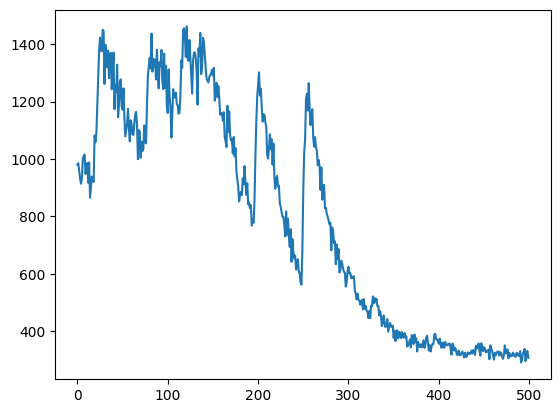

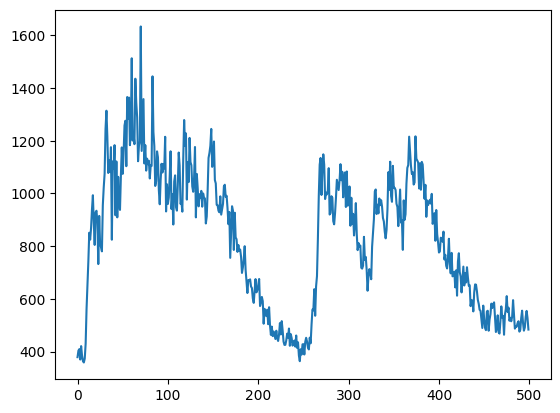

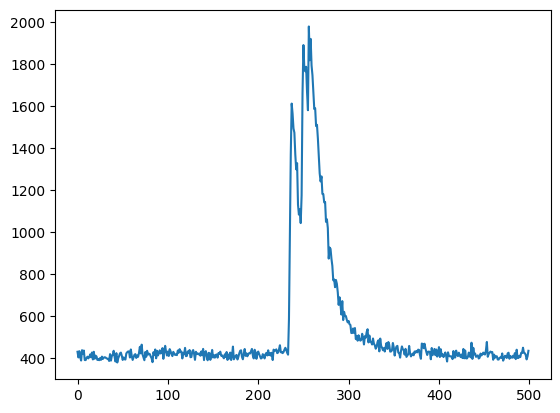

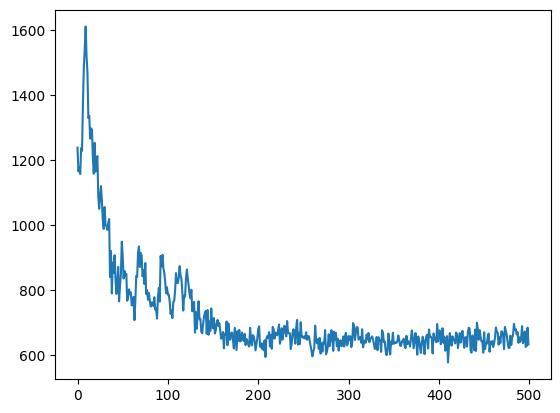

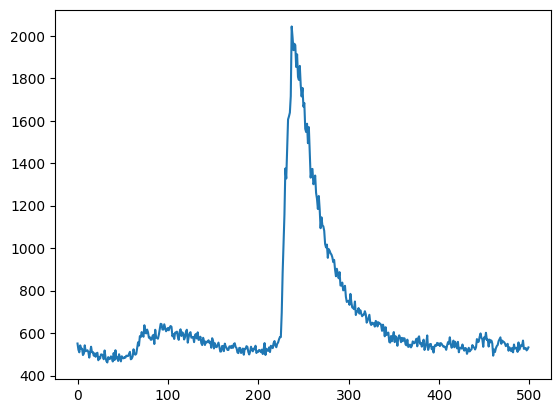

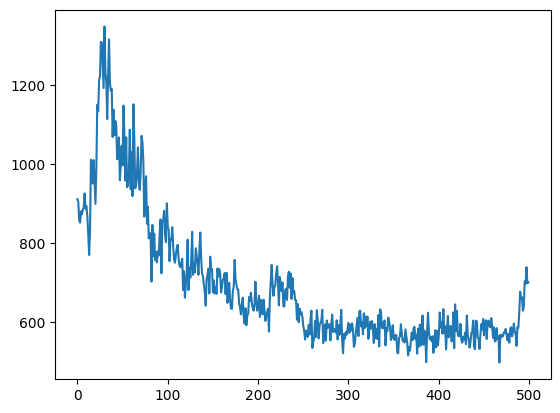

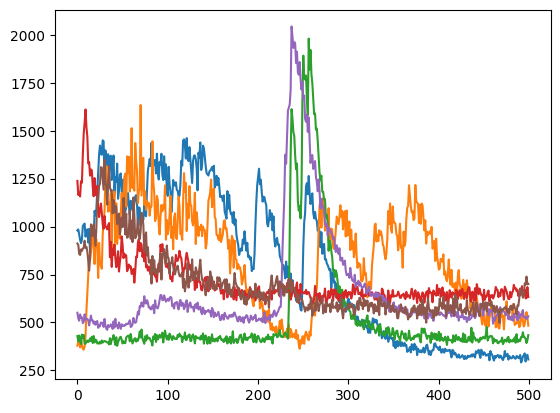

In [11]:
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import tifffile
from google.colab import drive
from PIL import Image
import numpy as np

# Find the tif file in google drive
drive.mount('/content/drive')
file = "/content/drive/MyDrive/Neural_Signals_and_Computation_HW1/TEST_MOVIE_00001-small.tif"

# Load tif file into numpy array and image
data = tifffile.imread(file)

data_max = data[0]
data_min = data[0]
for i in range(data.shape[0]):
  data_max = np.maximum(data[i], data_max)
  data_min = np.minimum(data[i], data_min)

data_range = np.subtract(data_max, data_min)

# Apply Gaussian blur to reduce noise
def gaussian_filter(image, sigma=1):
    # Define a Gaussian kernel
    kernel_size = int(6 * sigma + 1)
    kernel = np.fromfunction(
        lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x-(kernel_size-1)/2)**2 + (y-(kernel_size-1)/2)**2)/(2*sigma**2)),
        (kernel_size, kernel_size))
    kernel /= np.sum(kernel)  # Normalize the kernel

    # Convolve the image with the Gaussian kernel
    filtered_image = np.zeros_like(image, dtype=np.float64)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            filtered_image[i, j] = np.sum(image[max(0, i-(kernel_size-1)//2):min(image.shape[0], i+(kernel_size+1)//2),
                                                max(0, j-(kernel_size-1)//2):min(image.shape[1], j+(kernel_size+1)//2)] *
                                           kernel[:min(image.shape[0], i+(kernel_size+1)//2)-max(0, i-(kernel_size-1)//2),
                                                  :min(image.shape[1], j+(kernel_size+1)//2)-max(0, j-(kernel_size-1)//2)])
    return filtered_image
data_range = gaussian_filter(data_range, 3)

# Create the ROI Binary Mask
data_max = np.max(data_range)
data_min = np.min(data_range)
data_threshold = (data_max - data_min) * 0.5 + data_min
for i in range(len(data_range)):
  for j in range(len(data_range[i])):
    if data_range[i][j] < data_threshold:
      data_range[i][j] = 0
    else:
      data_range[i][j] = 1

# Initialize Seeds of ROIs
seeds = [(352, 58), (118, 144), (343, 269), (416, 395), (170, 483), (126, 469)]
c = 1
for seed in seeds:
  data_range[seed[1]][seed[0]] += c
  c += 1

# Differentitate the Seeds
def update_group(i, j, width, height):
  check_tile = []
  if (i - 1) > 0:
    check_tile.append((-1, 0))
  if (j - 1) > 0:
    check_tile.append((0, -1))
  if (i + 1) < width:
    check_tile.append((1, 0))
  if (j + 1) < height:
    check_tile.append((0, 1))
  return check_tile

for x in range(10):
  for i in range(len(data_range)):
    for j in range(len(data_range[i])):
      if data_range[i][j] == 1:
        check_tile = update_group(i, j, len(data_range), len(data_range[i]))
        for tile in check_tile:
          if data_range[i + tile[1]][j + tile[0]] > data_range[i][j]:
            data_range[i][j] = data_range[i + tile[1]][j + tile[0]]

# Find Time Traces (We use mean of each ROI for each frame)
trace1 = []
trace2 = []
trace3 = []
trace4 = []
trace5 = []
trace6 = []

for frame in data:
  roi1 = []
  roi2 = []
  roi3 = []
  roi4 = []
  roi5 = []
  roi6 = []
  for i in range(len(frame)):
    for j in range(len(frame[i])):
      if data_range[i][j] == 2:
        roi1.append(frame[i][j])
      if data_range[i][j] == 3:
        roi2.append(frame[i][j])
      if data_range[i][j] == 4:
        roi3.append(frame[i][j])
      if data_range[i][j] == 5:
        roi4.append(frame[i][j])
      if data_range[i][j] == 6:
        roi5.append(frame[i][j])
      if data_range[i][j] == 7:
        roi6.append(frame[i][j])
  trace1.append(np.mean(roi1))
  trace2.append(np.mean(roi2))
  trace3.append(np.mean(roi3))
  trace4.append(np.mean(roi4))
  trace5.append(np.mean(roi5))
  trace6.append(np.mean(roi6))

# Plot Average Flourescence of Each ROI
plt.figure()
print('Trace1, ROI Label: 2')
plt.plot(trace1)
plt.figure()
print('Trace2, ROI Label: 3')
plt.plot(trace2)
plt.figure()
print('Trace3, ROI Label: 4')
plt.plot(trace3)
plt.figure()
print('Trace4, ROI Label: 5')
plt.plot(trace4)
plt.figure()
print('Trace5, ROI Label: 6')
plt.plot(trace5)
plt.figure()
print('Trace6, ROI Label: 7')
plt.plot(trace6)
plt.figure()
print('All Traces')
plt.plot(trace1)
plt.plot(trace2)
plt.plot(trace3)
plt.plot(trace4)
plt.plot(trace5)
plt.plot(trace6)

# Plot the summary images
# Create a square layout for the plot
layout = go.Layout(
    width=data.shape[1],  # Set the width of the plot
    height=data.shape[2],  # Set the height of the plot
    xaxis=dict(range=[0, data.shape[1]]),  # Set the x-axis range to match the width of the image
    yaxis=dict(range=[0, data.shape[2]]),  # Set the y-axis range to match the height of the image
    margin=dict(l=0, r=0, t=0, b=0),  # Set the margins to 0 to remove unnecessary spacing
)

fig_range = go.Figure(data=go.Heatmap(z=data_range), layout=layout)
fig_range.show()


Using the ROI binary mask we made before from the data_range summary, we then differentiate them into 6 distinct regions for the whole image. This can be seen in the heatmap for each region of interest as a different heat label to show where each ROI is that we want to study. From hand, we selected a seed pixel for each ROI to serve as an initial value to then color and differentiate.

Afterwards, we iterate through the normal data set, all the frames and divide the data for each frame for each region of interest. Ultimately, we obsevr their activity as an average of the flourescence in each frame for each roi over time.